In [72]:
#https://www.youtube.com/watch?v=GrJP9FLV3FE

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc("font", size=14)
import pandas as pd
import numpy as np
import datetime

import xgboost as xgb
import graphviz
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import os
os.environ["PATH"] += os.pathsep + r"D:/Python/Graphviz/bin/"


In [74]:
def full_log_likelihood(w, X, y):
    score = np.dot(X, w).reshape(1, X.shape[0])
    return np.sum(-np.log(1 + np.exp(score))) + np.sum(y * score)

def null_log_likelihood(w, X, y):
    z = np.array([w if i == 0 else 0.0 for i, w in enumerate(w.reshape(1, X.shape[1])[0])]).reshape(X.shape[1], 1)
    score = np.dot(X, z).reshape(1, X.shape[0])
    return np.sum(-np.log(1 + np.exp(score))) + np.sum(y * score)

def mcfadden_rsquare(w, X, y):
    return 1.0 - (full_log_likelihood(w, X, y) / null_log_likelihood(w, X, y))

def mcfadden_adjusted_rsquare(w, X, y):
    k = float(X.shape[1])
    return 1.0 - ((full_log_likelihood(w, X, y) - k) / null_log_likelihood(w, X, y))
def efron_rsquare(y, y_pred):
    n = float(len(y))
    t1 = np.sum(np.power(y - y_pred, 2.0))
    t2 = np.sum(np.power((y - (np.sum(y) / n)), 2.0))
    return 1.0 - (t1 / t2)
def true_probabilities (p,a):
    tp =p/(p+(1-p)/a)
    return tp
def dateMonths(dt):
    return dt.year*12+dt.month
def calcAge(dt):
    return (dateMonths(datetime.date.today())-dateMonths(dt))/12
def toDate(dt):
    return datetime.datetime.strptime(dt,'%Y-%m-%d').date()

In [75]:
file_path = r"E:\Various\Data Science\Tsiptsis\Exercise 1\TimeDeposit_PropensityModeling_Sample1.txt"

In [76]:
df = pd.read_csv(file_path,sep ='\t')

In [77]:
recode = {"T":"1","F":"0"}

df['Time_Deposits_Flag'] = df['Time_Deposits_Flag'].map(recode)
df['Time_Deposits_Flag'].astype(int)

0         0
1         0
2         0
3         0
4         0
         ..
119995    0
119996    1
119997    0
119998    0
119999    0
Name: Time_Deposits_Flag, Length: 120000, dtype: int32

In [78]:
for col in df.columns[1:-1]:       
       if df[col].dtype =='object' and col not in ['Birth_Date','Ref_Date']:
            
            df = pd.get_dummies(df, prefix=col + '_', columns=[col])

In [79]:
for col in df.columns[1:-1]:       
       if df[col].dtype =='float' and ('_Num' in col or '_Flag' in col):
            
            df[col] = df[col].astype('int')

In [80]:
df['Time_Deposits_Flag'] = df['Time_Deposits_Flag'].astype('int')

In [81]:
df['Total_Income'] = df['Total_Income'].astype('float')

In [82]:
df['Birth_Date'] = df['Birth_Date'].apply(toDate)
df['Ref_Date'] = df['Ref_Date'].apply(toDate)

In [83]:
df['Age'] = df['Birth_Date'].apply(calcAge)
df['Tenure'] = df['Ref_Date'].apply(calcAge)

In [84]:
df = df.drop(['Birth_Date','Ref_Date'],axis = 1)

In [85]:
df.dtypes #XGBOOST does not work with objects!!!!

Customer_ID                               int64
Children_Num                              int64
Total_Income                            float64
Payroll_Flag                              int64
Business_Flag                             int64
Saving_Current_Accounts_Flag              int32
Investment_Products_Flag                  int32
Insurance_Products_Flag                   int32
Business_Loans_Flag                       int32
Housing_Loans_Flag                        int32
Consumer_Loans_Flag                       int32
Credit_Cards_Flag                         int32
Saving_Current_Balance                  float64
Investment_Products_Balance             float64
Insurance_Balances                      float64
Business_Loans_Balance                  float64
Housing_Loans_Balance                   float64
Consumer_Loans_Balance                  float64
Credit_Cards_Balance                    float64
Branch_Trans_Num                          int32
ATM_Trans_Num                           

In [86]:
f_count = df[df['Time_Deposits_Flag']== 0].iloc[:,0].count()
t_count = df[df['Time_Deposits_Flag']== 1].iloc[:,0].count()
weights = {1:1,0:t_count*3/f_count}

In [87]:
true_indices = df[df.Time_Deposits_Flag == 1].index
false_indices = df[df.Time_Deposits_Flag == 0].index

In [88]:
random_false_indices = np.random.choice(false_indices, t_count*3, replace = False)
random_false_indices = np.array(random_false_indices)

In [89]:
under_sample_indices = np.concatenate([true_indices,random_false_indices])

In [90]:
X = df.drop(['Time_Deposits_Flag','Customer_ID'],axis = 1).iloc[under_sample_indices,:]

In [91]:
y = df['Time_Deposits_Flag'].iloc[under_sample_indices]

In [92]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = y)

In [93]:
sum(y_train)/len(y_train),sum(y_test)/len(y_test),len(y_train)/sum(y_train)

(0.25006232859636, 0.24981301421091998, 3.999002991026919)

In [94]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic', missing = None,
                            #,scale_pos_rate = len(y_train)/sum(y_train),
                            learning_rate = 0.1,
                           n_estimators = 100,            
                            max_depth = 4)

In [95]:
clf_xgb.fit(X_train,
            y_train,
            verbose = True,
            early_stopping_rounds = 30,
            eval_metric = 'aucpr',
            eval_set = [(X_test,y_test)])
                       

[0]	validation_0-aucpr:0.434
Will train until validation_0-aucpr hasn't improved in 30 rounds.
[1]	validation_0-aucpr:0.46842
[2]	validation_0-aucpr:0.48137
[3]	validation_0-aucpr:0.484024
[4]	validation_0-aucpr:0.492011
[5]	validation_0-aucpr:0.490467
[6]	validation_0-aucpr:0.490372
[7]	validation_0-aucpr:0.491591
[8]	validation_0-aucpr:0.497317
[9]	validation_0-aucpr:0.500313
[10]	validation_0-aucpr:0.49767
[11]	validation_0-aucpr:0.502697
[12]	validation_0-aucpr:0.504611
[13]	validation_0-aucpr:0.503993
[14]	validation_0-aucpr:0.505282
[15]	validation_0-aucpr:0.50908
[16]	validation_0-aucpr:0.50955
[17]	validation_0-aucpr:0.512942
[18]	validation_0-aucpr:0.512563
[19]	validation_0-aucpr:0.513959
[20]	validation_0-aucpr:0.514351
[21]	validation_0-aucpr:0.515325
[22]	validation_0-aucpr:0.519344
[23]	validation_0-aucpr:0.520595
[24]	validation_0-aucpr:0.519188
[25]	validation_0-aucpr:0.519988
[26]	validation_0-aucpr:0.521163
[27]	validation_0-aucpr:0.520224
[28]	validation_0-aucpr:0.51

XGBClassifier(max_depth=4)

In [96]:
print(classification_report(y_train, clf_xgb.predict(X_train)))

              precision    recall  f1-score   support

           0       0.84      0.97      0.90      3008
           1       0.82      0.45      0.58      1003

    accuracy                           0.84      4011
   macro avg       0.83      0.71      0.74      4011
weighted avg       0.84      0.84      0.82      4011



In [97]:
print(classification_report(y_test, clf_xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1003
           1       0.62      0.35      0.45       334

    accuracy                           0.79      1337
   macro avg       0.72      0.64      0.66      1337
weighted avg       0.77      0.79      0.76      1337



In [98]:
X = df.drop('Time_Deposits_Flag',axis = 1)
y = df['Time_Deposits_Flag']

In [99]:
print(classification_report(y, clf_xgb.predict(X.drop(['Customer_ID'], axis = 1))))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96    118663
           1       0.06      0.43      0.11      1337

    accuracy                           0.92    120000
   macro avg       0.53      0.68      0.54    120000
weighted avg       0.98      0.92      0.95    120000



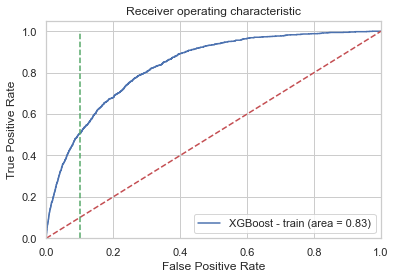

In [100]:
logit_roc_auc = roc_auc_score(y, clf_xgb.predict(X.drop(['Customer_ID'], axis = 1)))
fpr, tpr, thresholds = roc_curve(y, clf_xgb.predict_proba(X.drop(['Customer_ID'], axis = 1))[:,1])
auc_train = roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='XGBoost - train (area = %0.2f)' % auc_train)
plt.plot([0, 1], [0, 1],'r--')
plt.plot([0.1,0.1],[0,1],'g--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [101]:
df_lift = pd.DataFrame(zip(y,clf_xgb.predict(X.drop(['Customer_ID'], axis = 1))),columns =['Actual','Predicted']).sort_values(by ='Predicted',ascending = False)

In [102]:
'lift at 10% is {:.03f}'.format(df_lift['Actual'].head(12000).sum()/df_lift['Actual'].sum()/0.1)

'lift at 10% is 4.450'

In [103]:
nodes_params = {'shape':'box',
              'style':'filled,rounded',
              'fillcolor':'#407294'}
leaf_params = {'shape':'box',
              'style':'filled,rounded',
              'fillcolor':'#d5d0e2'}

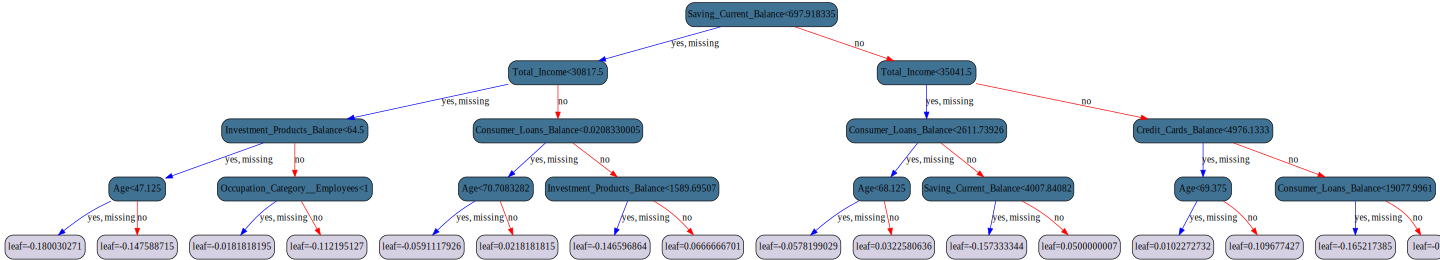

In [109]:
xgb.to_graphviz(clf_xgb,size = "20,10",condition_node_params = nodes_params,leaf_node_params = leaf_params,num_trees = 0)

In [105]:
bst = clf_xgb.get_booster()

In [106]:
tg=bst.get_score(importance_type = 'weight') 
#weight:number of time a feature is used in all trees
#gain : the average gain of the feature across all splits
#cover: the average cover of the feature across all splits
#total_gain, total_cover
#The Gain implies the relative contribution of the corresponding feature to the model 
#calculated by taking each feature's contribution for each tree in the model. 
#A higher value of this metric when compared to another feature implies it is more important for generating a prediction.
#The Cover metric means the relative number of observations related to this feature. 
#For example, if you have 100 observations, 4 features and 3 trees, 
#and suppose feature1 is used to decide the leaf node for 10, 5, and 2 observations in tree1, tree2 and tree3 respectively; then the metric will count cover for this feature as 10+5+2 = 17 observations. This will be calculated for all the 4 features and the cover will be 17 expressed as a percentage for all features' cover metrics.

In [107]:
pd.DataFrame(zip(list(tg.keys()),list(tg.values())),columns = ['Feature','Weight']).sort_values(by = 'Weight', ascending = False)

,Feature,Weight
3,Age,144
1,Total_Income,136
0,Saving_Current_Balance,117
22,Withdrawl_Trans_Amount,80
7,Deposit_Trans_Amount,65
6,Credit_Cards_Balance,63
5,Consumer_Loans_Balance,53
15,Transfer_Trans_Amount,48
2,Investment_Products_Balance,44
14,Payment_Trans_Amount,41


In [47]:
params = {
        'learning_rate': [0.1,0.2],
        #'scale_pos_rate' : [len(y_train)/sum(y_train),2*len(y_train)/sum(y_train)],
        'max_depth': [4, 5, 6]
        }
grid = GridSearchCV(estimator=clf_xgb, param_grid=params, scoring='roc_auc', n_jobs=4,  verbose=3 )

grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:   15.4s finished


GridSearchCV(estimator=XGBClassifier(), n_jobs=4,
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [4, 5, 6]},
             scoring='roc_auc', verbose=3)

In [48]:
#print('\n All results:')
#print(grid.cv_results_)
#print('\n Best estimator:')
#print(grid.best_estimator_)
#print('\n Best score:')
#print(grid.best_score_ * 2 - 1)
print('\n Best parameters:')
print(grid.best_params_)
results = pd.DataFrame(grid.cv_results_)
#results.to_csv('xgb-grid-search-results-01.csv', index=False)

#y_test = grid.best_estimator_.predict_proba(X)
#results_df = pd.DataFrame(data={'id':test_df['id'], 'target':y_test[:,1]})
#results_df.to_csv('submission-grid-search-xgb-porto-01.csv', index=False)


 Best parameters:
{'learning_rate': 0.1, 'max_depth': 4}
